# Cloud Optical Thickness Prediction from Imaging Satellite Instruments

In [1]:
import os
import math
import torch
from torch import nn
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import xarray as xr
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.special import logit
from multiprocessing import Process
from time import perf_counter

import matplotlib.pyplot as plt

In [2]:
# Description: 1 layer - 64 neurons, 200 epochs, cut off = -3, lr = 0.0001
expname = '053104oci'

In [3]:
file_path ='rt_nn_cloud_training_data_20230310.nc'
ds = xr.open_dataset(file_path)
ds

<xarray.Dataset>
Dimensions:                        (npoints: 250000, nbands_oci: 223, nbands_modis: 11, nbands_viirs: 10)
Coordinates:
  * nbands_oci                     (nbands_oci) float32 350.0 ... 2.261e+03
  * nbands_modis                   (nbands_modis) float32 412.0 ... 2.13e+03
  * nbands_viirs                   (nbands_viirs) float32 412.0 ... 2.25e+03
Dimensions without coordinates: npoints
Data variables:
    solar_zenith_angle             (npoints) float32 ...
    viewing_zenith_angle           (npoints) float32 ...
    relative_azimuth_angle         (npoints) float32 ...
    albedo_type                    (npoints) int16 ...
    oci_reflectances               (nbands_oci, npoints) float32 ...
    modis_reflectances             (nbands_modis, npoints) float32 ...
    viirs_reflectances             (nbands_viirs, npoints) float32 ...
    scene_type                     (npoints) int16 ...
    log10_cloud_optical_thickness  (npoints) float32 ...
    spress                         (npoints) float32 ...
    h2o                            (npoints) float32 ...
    o3                             (npoints) float32 ...
Attributes:
    description:             Radiative transfer-based labelled training data ...
    suffix:                  nc
    version:                 Created 20230310
    contact_person_address:  NASA/GSFC, Mail Code 616, 8800 Greenbelt Road, G...
    contact_person_email:     andrew.sayer@nasa.gov
    contact_person_name:      Andrew Sayer
    contact_person_role:     Scientific/technical contact
    data_set_language:       en
    file_format:             NetCDF4

In [4]:
# Define variables
oci_reflectances = ds["oci_reflectances"].values 
modis_reflectances = ds["modis_reflectances"].values 
viirs_reflectances = ds["viirs_reflectances"].values 
nbands_oci = ds["nbands_oci"].values
nbands_modis = ds["nbands_modis"].values
nbands_viirs = ds["nbands_viirs"].values
angles = ds[["solar_zenith_angle", "viewing_zenith_angle", "relative_azimuth_angle"]].to_array().values
h2o = ds["h2o"].values
o3 = ds["o3"].values
scene_type = ds["scene_type"].values
albedo_type = ds["albedo_type"].values
spress = ds["spress"].values
cot = ds["log10_cloud_optical_thickness"].values

### Data preprocess

In [5]:
# Define a minmax scaler
def minmaxscaler(reflectances):
        if len(reflectances.shape) == 1:
                reflectances_sc = (reflectances-reflectances.min())/(reflectances.max() - reflectances.min())
        else:
                reflectances_sc = []
                for i in range(len(reflectances)):
                        reflectances_sc_tem = (reflectances[i]-reflectances[i].min())/(reflectances[i].max()-reflectances[i].min())
                        reflectances_sc.append(reflectances_sc_tem)
        return np.array(reflectances_sc)
                

In [6]:
# Define labels for albedo type
land = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,18]
snow = [15,19,20]
desert = [16, 16]
ocean_water = [17, 17]
albedo = [land, snow, desert, ocean_water]

def albedo_category(albedo_type):
    albedo_type_sc = []
    for k in range(len(albedo)):
        i = 0
        albedo_1hot = []
        for i in range(len(albedo_type)):
            if albedo_type[i] in albedo[k]:
                albedo_1hot.append(1)
            else:
                albedo_1hot.append(0)
        albedo_type_sc.append(albedo_1hot)
    return np.array(albedo_type_sc)

In [7]:
"""
Reflectances, h2o, o3, spress: minmax normalize to [0,1]
Angles: take cosine and normalize to [0,1]
scen_type: no preprocessing
albedo_type: break down into 4 categories
cot: set 0 as -2
"""
oci_reflectances_sc = minmaxscaler(oci_reflectances)
h2o_sc = minmaxscaler(h2o)
o3_sc = minmaxscaler(o3)
spress_sc = minmaxscaler(spress)
angles_sc = minmaxscaler(np.cos(angles))
albedo_type_sc = np.float32(albedo_category(albedo_type))

In [8]:
cot_sc = np.nan_to_num(cot, nan=5) 
max_value = cot_sc.max()
min_value = cot_sc.min()
cot_sc = minmaxscaler(cot_sc)


In [15]:
print(max_value, min_value)
if ()

5.0 -1.5


## Concatenate variables and split training-testing dataset

In [9]:
X = np.concatenate((oci_reflectances_sc, h2o_sc[None, :], o3_sc[None, :], spress_sc[None, :], albedo_type_sc, angles_sc), axis=0) # n x m, where n = 22
# X = np.transpose(X) # transpose into a m x n matrix , n = 22 (aka features) and m = rows (aka observations)
X = np.float32(X)
# Y represents the response vector (binary),,,, m by 1, m = rows (aka observations)
Y = cot_sc
# Y = np.reshape(Y, (-1, 1)) # reshape to m x 1 array

In [10]:
print(X.shape, Y.shape)

(233, 250000) (250000,)


In [11]:
X = np.transpose(X)

In [12]:
Y = np.reshape(Y, (-1, 1))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 

# Prepare Data for Training

In [14]:
X_train_t = torch.from_numpy(X_train.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.float32))
X_val_t = torch.from_numpy(X_val.astype(np.float32))
y_val_t = torch.from_numpy(y_val.astype(np.float32))

In [16]:
dataset_train = Data.TensorDataset(X_train_t, y_train_t)
dataset_val = Data.TensorDataset(X_val_t, y_val_t)
train_loader = DataLoader(dataset = dataset_train, batch_size = 64, shuffle=True, pin_memory=True)
validate_loader = DataLoader(dataset = dataset_val, batch_size = 64, shuffle=True, pin_memory=True)

# Network

In [17]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self, input_size):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(input_size, 128),
      # nn.BatchNorm1d(64),
      nn.ReLU(),
      nn.Linear(128, 64),
      # nn.BatchNorm1d(64),
      nn.ReLU(),
      nn.Linear(64, 32),
      # nn.BatchNorm1d(32),
      nn.ReLU(),
      nn.Linear(32, 1)
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

# Optimization

In [18]:
# Initialize the MLP
mlp = MLP(input_size=X_train_t.shape[1])
  
# Define the loss function and optimizer
loss_function = nn.L1Loss() # Pay attention to the threshold between cloud and non-cloud pxiels # add penalty to -1.5
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.00001)

In [ ]:
# Run the training loop
train_loss_all = []
valid_loss_all = []
for epoch in range(250): 
  
  # Print epoch
  print(f'Starting epoch {epoch+1}')
  
  # Set current loss value
  train_loss = 0.0
  valid_loss = 0.0
  train_num = 0
  valid_num = 0
  
  # Iterate over the DataLoader for training data
  for step, (b_x,b_y) in enumerate(train_loader):
    output = mlp(b_x)*(max_value-min_value)+min_value
    ground_truth = b_y*(max_value-min_value)+min_value
    loss = loss_function(output, ground_truth)
    optimizer.zero_grad
    loss.backward()
    optimizer.step()
    train_loss +=loss.item() * b_x.size(0)
    train_num += b_x.size(0)
  train_loss_all.append(train_loss / train_num)

  for setp, (c_x, c_y) in enumerate(validate_loader):
    output_valid = mlp(c_x)*(max_value-min_value)+min_value
    loss_v = loss_function(output_valid,(c_y*(max_value-min_value)+min_value))
    valid_loss +=loss_v.item() * c_x.size(0)
    valid_num += c_x.size(0)

  valid_loss_all.append(valid_loss / valid_num) # revise for other experiments
  print("Train Loss: {}, Valid Loss: {}".format ((train_loss / train_num), (valid_loss / valid_num)))  

# Process is complete.
print('Training process has finished.')

In [21]:
PATH = './models/{}_oci.pth'.format(expname)
torch.save(mlp.state_dict(), PATH)

# Training Loss Plot

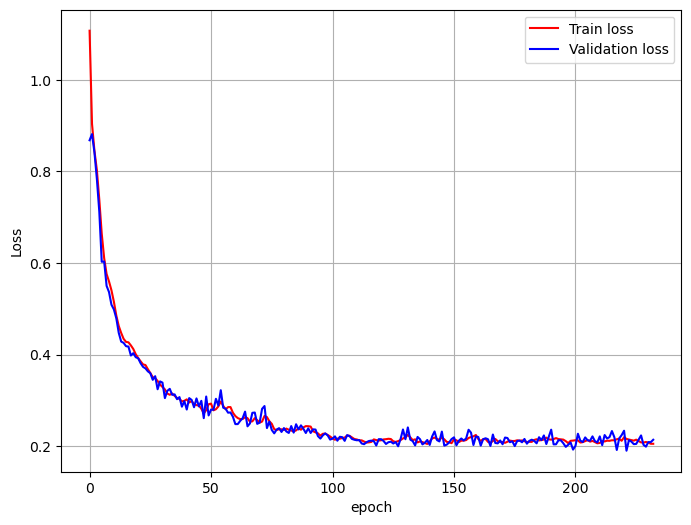

In [22]:
plt.figure(figsize = (8,6))
plt.plot(train_loss_all, 'r-', label = 'Train loss')
plt.plot(valid_loss_all, 'b-', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.savefig('/Users/xingyanli/Lab/gestar2_regression/results/{}_loss.png'.format(expname))
plt.show()

# Test

In [23]:
# Test data loader
X_test_t = torch.from_numpy(X_test.astype(np.float32))
y_test_t = torch.from_numpy(y_test.astype(np.float32))
dataset_test = Data.TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(dataset = dataset_test, batch_size = len(y_test_t), shuffle=True, pin_memory=True)

# Load model
test_loss = 0.0
test_num = 0
for step, (d_x,d_y) in enumerate(test_loader):
    output_test = mlp(d_x)*(max_value-min_value)+min_value
    target = d_y*(max_value-min_value)+min_value
    output_test = output_test.detach().cpu().numpy()
    target = target.detach().cpu().numpy()


In [24]:
MSE = np.square(np.subtract(target,output_test)).mean() 
RMSE = math.sqrt(MSE)
print("MSE: {}, RMSE: {}".format(MSE, RMSE))

MSE: 0.18377800285816193, RMSE: 0.42869336693977655


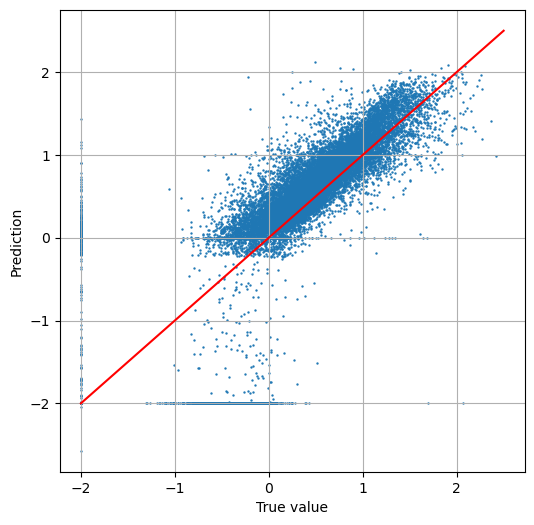

In [25]:
plt.figure(figsize = (6,6))
plt.scatter(target, output_test, s=0.5)
plt.plot([-2,2.5], [-2,2.5], 'r-')
plt.grid()
plt.xlabel('True value')
plt.ylabel('Prediction')
plt.savefig("/Users/xingyanli/Lab/gestar2_regression/results/{}_scatter.png".format(expname))
plt.show()


In [ ]:
test_truth = np.hstack((target, output_test))
test_truth

array([[-2.        , -2.0001543 ],
       [ 0.00365686,  0.13931799],
       [ 0.655797  ,  0.89066267],
       ...,
       [-0.08772182, -0.07664835],
       [-0.26186395, -0.14435816],
       [-2.        , -2.0001543 ]], dtype=float32)

In [ ]:
np.savetxt('results/{}.csv'.format(expname), test_truth,  delimiter=',')
